In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# read
analog = pd.read_excel('/home/ubuntu/tutorial_kyg/koiiadata/N_ANALOG_DATA_ETC_01_0037.xlsx')
df_d = pd.read_excel('/home/ubuntu/tutorial_kyg/koiiadata/N_DIGITAL_DATA.xlsx')

In [4]:
# digital data 전처리

# dm_code 종류 오름차순
dm_codes = sorted(list(set(df_d['dm_code'])))

# 오류 코드별 분류
groupbydm = dict()
for i in dm_codes:
    groupbydm[i] = df_d[df_d['dm_code']==i]

dup_iloc = dict()
for i in dm_codes:
    temp = []
    for j in range(1,len(groupbydm[i])):
        if groupbydm[i].iloc[j-1]['value'] == groupbydm[i].iloc[j]['value']:
            temp.append(j)
    dup_iloc[i] = temp

groupbydm_ = dict()
temp = []
for i in dm_codes:
    for j in dup_iloc[i]:
        temp.append(groupbydm[i].iloc[j-1].name)
    groupbydm_[i] = groupbydm[i].drop(temp)
    temp = []

start1 = []
for i in dm_codes:
    if int(groupbydm_[i].head(1)['value']) == 0:
        start1.append(i)
for i in start1:
    groupbydm_[i].drop(groupbydm_[i].head(1).index, inplace=True)
    
last1 = []
for i in dm_codes:
    if int(groupbydm_[i].tail(1)['value']) == 1:
        last1.append(i)
for i in last1:
    groupbydm_[i].drop(groupbydm_[i].tail(1).index, inplace=True)

# df_stop에 시작 시간에 맞춘 time_lapse 기록
df_stop = dict()
for i in dm_codes:
    time_lapse = []
    for j in range(0, len(groupbydm_[i]), 2):
        time_lapse.append(groupbydm_[i].iloc[j+1]['create_time'] - groupbydm_[i].iloc[j]['create_time'])
    df_stop[i] = groupbydm_[i][::2].copy()
    df_stop[i]['time_lapse'] = time_lapse
for i in dm_codes:
    df_stop[i]['finish_time'] = list(groupbydm_[i][1::2]['create_time'])

df_37stop = df_stop[dm_codes[132]]
for i in range(133,160):
    df_37stop = df_37stop.append(df_stop[dm_codes[i]])

df_37stop.sort_index(inplace = True)

In [5]:
# 아날로그 전처리

analog = analog.dropna(axis=0)

analog = analog.loc[:,(analog != 0).any(axis=0)]

analog.reset_index(inplace=True)
#모든 값 scaling
scaler = MinMaxScaler()

for i in analog.loc[:,'d10':]:
    analog.loc[:,i] = scaler.fit_transform(analog[[i]])

In [6]:
# 이상 인풋데이터
anomaly = []
for i in df_37stop['create_time']:
    idx = analog[analog['create_time']==i].index[0]
    ls = []
    for j in range(idx-25,idx-15):
        ls.append(list(analog.iloc[j,9:]))
    anomaly.append(ls)
    ls = []
    for j in range(idx-15,idx-5):
        ls.append(list(analog.iloc[j,9:]))
    anomaly.append(ls)
    ls = []
    for j in range(idx-5,idx+5):
        ls.append(list(analog.iloc[j,9:]))
    anomaly.append(ls)

anom_arr = np.array(anomaly)
display(anom_arr.shape)

(699, 10, 29)

In [7]:
# 정상인 데이터만 모으기
finish_time = []
time_lapse = []
for i,s in df_37stop.iterrows():
    finish_time.append(s['finish_time'])
    time_lapse.append(int(s['time_lapse'].total_seconds()))

anom_time = []
onesec = pd.to_timedelta(1, unit='S')

for i in zip(finish_time, time_lapse):
    ttmp = i[0] + onesec*300
    anom_time.append(ttmp)
    for i in range(600+i[1]):
        ttmp = ttmp - onesec
        anom_time.append(ttmp)

anom_time = sorted(list(set(anom_time)))

timeset = sorted(list(set(analog['create_time']) - set(anom_time)))
normal = analog[analog['create_time'].isin(timeset)].loc[:,'d10':].to_numpy().tolist()

In [8]:
# 정상 데이터
norm = []
idx = 0
for i in df_37stop['create_time']:
    for j in range(idx,len(timeset)):
        if timeset[j] >= i:
            norm.append(normal[idx:j-1])
            idx = j
            break

#
norm_list = []
for i in norm:
    for j in range(len(i)//10):
        norm_list.append(i[j*10:(j+1)*10])

norm_all = np.array(norm_list)
print(norm_all.shape)

(15611, 10, 29)


In [9]:
norm_arr = norm_all[::22][:699]
display(norm_arr.shape)

(699, 10, 29)

norm_arr -> 정상 인풋

anom_arr -> 정지 인풋

In [95]:
y_ = np.concatenate((np.full(15611,0), np.full(699,1)), axis=0)
y_.shape

(16310,)

In [94]:
x_ = np.concatenate((norm_all, anom_arr), axis=0)
x_.shape

(16310, 10, 29)

In [10]:
x = np.concatenate((norm_arr, anom_arr), axis=0)
print(x.shape)

(1398, 10, 29)


In [11]:
y = np.concatenate((np.full(699,0),np.full(699,1)))
print(y.shape)

(1398,)


In [97]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [96]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=0.2, random_state=42)

### 데이터 생성

In [12]:
#test data 확보
x_test_data = np.concatenate((norm_all[:100],anom_arr[:156]), axis=0)
y_test_data = np.concatenate((np.full(100,0),np.full(156,1)))
print(x_test_data.shape)
print(y_test_data.shape)

#전체 데이터(test data 제외) 합치고 target 데이터 생성
all_data = np.concatenate((norm_all[100:], anom_arr[156:]), axis =0)
print(all_data.shape)
target_data = np.concatenate((np.full(15511,0),np.full(543,1)))
print(target_data.shape)

(256, 10, 29)
(256,)
(16054, 10, 29)
(16054,)


In [13]:
all_data[0]

array([[0.00877193, 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.2       , 0.00612089, 0.5       , 1.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
        0.02362205, 0.5       , 0.33333333, 1.        , 0.        ,
        1.        , 0.5       , 0.25675676, 0.75      , 0.25617978,
        0.22222222, 0.00404585, 0.8       , 0.760181  ],
       [0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.2       , 0.00612089, 0.5       , 1.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
        0.02362205, 0.5       , 0.33333333, 1.        , 0.        ,
        1.        , 0.5       , 0.25675676, 0.75      , 0.25617978,
        0.22222222, 0.00404585, 0.8       , 0.760181  ],
       [0.00877193, 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.2       , 0.00612089, 0.5       , 1.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
  

### 1. SMOTE사용

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [15]:
# oversample = SMOTE()
# X, y = oversample.fit_resample(all_data, target_data)

dim_1 = all_data.shape[0] #16054
dim_2 = all_data.shape[1] #10
dim_3 = all_data.shape[2] #29

new_dim = dim_1 * dim_2
#160540 * 29
new_x_train = all_data.reshape(new_dim, dim_3)


new_target_data = []
#all_data 합친 만큰 target_data도 10개씩 target을 늘려줘야함
for i in range(len(target_data)):
    #print(target_data[i])
    new_target_data.extend([target_data[i]]*dim_2)

new_target_data = np.array(new_target_data)

# transform the dataset
oversample = SMOTE()
X_Train, Y_Train = oversample.fit_resample(new_x_train, new_target_data)
# summarize the new class distribution
counter = Counter(Y_Train)
print('The number of samples in TRAIN: ', counter)



x_train_SMOTE = X_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2, dim_3)

y_train_SMOTE = []
for i in range(int(X_Train.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_train_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
y_train_SMOTE = np.array(y_train_SMOTE)

The number of samples in TRAIN:  Counter({0: 155110, 1: 155110})


In [16]:
print(x_train_SMOTE.shape, y_train_SMOTE.shape)
print(x_test_data.shape, y_test_data.shape)

(31022, 10, 29) (31022,)
(256, 10, 29) (256,)


In [92]:
x_train_SMOTE[10000]

array([[0.00877193, 0.        , 1.        , 1.        , 0.        ,
        0.33333333, 0.        , 0.00612089, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
        0.04330709, 0.5       , 0.33333333, 0.        , 0.1       ,
        1.        , 0.        , 0.26576577, 0.75      , 0.26741573,
        0.22222222, 0.33917734, 0.8       , 0.67420814],
       [0.        , 0.        , 1.        , 1.        , 0.        ,
        0.33333333, 0.        , 0.00612089, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
        0.04330709, 0.5       , 0.33333333, 0.        , 0.1       ,
        1.        , 0.        , 0.26576577, 0.75      , 0.26741573,
        0.22222222, 0.33917734, 0.8       , 0.67420814],
       [0.00877193, 0.        , 1.        , 1.        , 0.        ,
        0.33333333, 0.        , 0.00612089, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.92857143, 0.        ,
  

### 2. Borderline-SMOTE

In [17]:
from imblearn.over_sampling import BorderlineSMOTE

In [18]:
# transform the dataset
oversample = BorderlineSMOTE()
X_Train, Y_Train = oversample.fit_resample(new_x_train, new_target_data)
# summarize the new class distribution
counter = Counter(Y_Train)
print('The number of samples in TRAIN: ', counter)



x_train_B_SMOTE = X_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2, dim_3)

y_train_B_SMOTE = []
for i in range(int(X_Train.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_train_B_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
y_train_B_SMOTE = np.array(y_train_B_SMOTE)

The number of samples in TRAIN:  Counter({0: 155110, 1: 155110})


In [25]:
print(x_train_B_SMOTE.shape, y_train_B_SMOTE.shape)
print(x_test_data.shape, y_test_data.shape)

(31022, 10, 29) (31022,)
(256, 10, 29) (256,)


### 3. ADASYN

In [19]:
from imblearn.over_sampling import ADASYN

In [37]:
# transform the dataset
oversample = ADASYN()
X_Train, Y_Train = oversample.fit_resample(new_x_train, new_target_data)
# summarize the new class distribution
counter = Counter(Y_Train)
print('The number of samples in TRAIN: ', counter)

tmp2 = np.concatenate((Y_Train[:155110],Y_Train[155149:]))
tmp = np.concatenate((X_Train[:155110],X_Train[155149:]))

x_train_ADASYN = tmp.reshape(int(tmp.shape[0]/dim_2), dim_2, dim_3)

y_train_ADASYN = []
for i in range(int(tmp.shape[0]/dim_2)):
    # print(i)
    value_list = list(tmp2.reshape(int(tmp.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_train_ADASYN.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
y_train_ADASYN = np.array(y_train_ADASYN)

The number of samples in TRAIN:  Counter({1: 155149, 0: 155110})


In [38]:
print(x_train_ADASYN.shape, y_train_ADASYN.shape)
print(x_test_data.shape, y_test_data.shape)
counter = Counter(y_train_ADASYN)
print('The number of samples in TRAIN: ', counter)

(31022, 10, 29) (31022,)
(256, 10, 29) (256,)
The number of samples in TRAIN:  Counter({0: 15511, 1: 15511})


In [39]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [53]:
model = tf.keras.Sequential([
          layers.Input(shape=(10,29)),
          layers.Dense(128, activation='relu'),
            layers.Dropout(0.4),
          layers.Dense(64, activation='relu'),
                layers.Dropout(0.5),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.6),

          layers.Dense(1, activation=activations.sigmoid)])
model.summary()
# mc = ModelCheckpoint('speech_number.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss='binary_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10, 128)           3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 10, 64)            8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 10, 1)            

# Smote Training

In [49]:
history = model.fit(x_train_SMOTE, y_train_SMOTE, validation_split=0.2, batch_size=32, epochs=150, callbacks=[callback])

Epoch 1/150
776/776 [==============================] - 4s 4ms/step - loss: 0.4820 - accuracy: 0.7376 - val_loss: 0.3521 - val_accuracy: 0.8656
Epoch 2/150
776/776 [==============================] - 3s 4ms/step - loss: 0.3243 - accuracy: 0.8540 - val_loss: 0.3601 - val_accuracy: 0.8894
Epoch 3/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2974 - accuracy: 0.8686 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 4/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2850 - accuracy: 0.8744 - val_loss: 0.2541 - val_accuracy: 0.9063
Epoch 5/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2725 - accuracy: 0.8816 - val_loss: 0.2775 - val_accuracy: 0.9014
Epoch 6/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2607 - accuracy: 0.8875 - val_loss: 0.2595 - val_accuracy: 0.9017
Epoch 7/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2550 - accuracy: 0.8908 - val_loss: 0.2189 - val_accuracy: 0.9061

In [52]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test_data, y_test_data, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2/2 [==============================] - 0s 3ms/step - loss: 1.8253 - accuracy: 0.6512
test loss, test acc: [1.825298547744751, 0.651171863079071]


In [60]:
import matplotlib.pyplot as plt

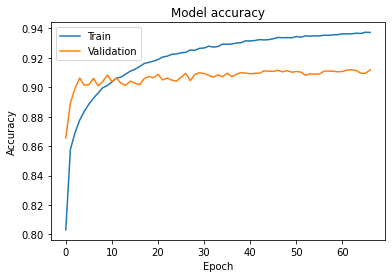

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

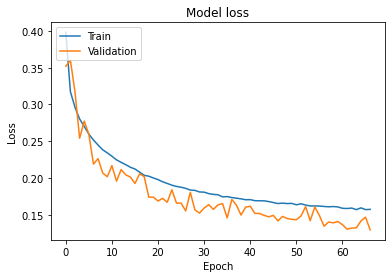

In [63]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Borderline Smote Training

In [66]:
history = model.fit(x_train_B_SMOTE, y_train_B_SMOTE, validation_split=0.2, batch_size=32, epochs=150, callbacks=[callback])

Epoch 1/150
776/776 [==============================] - 4s 4ms/step - loss: 0.4525 - accuracy: 0.7733 - val_loss: 0.2651 - val_accuracy: 0.9809
Epoch 2/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2684 - accuracy: 0.9000 - val_loss: 0.2462 - val_accuracy: 0.9832
Epoch 3/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2465 - accuracy: 0.9093 - val_loss: 0.1772 - val_accuracy: 0.9928
Epoch 4/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2318 - accuracy: 0.9150 - val_loss: 0.1639 - val_accuracy: 0.9928
Epoch 5/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2207 - accuracy: 0.9201 - val_loss: 0.1826 - val_accuracy: 0.9924
Epoch 6/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2157 - accuracy: 0.9222 - val_loss: 0.1607 - val_accuracy: 0.9935
Epoch 7/150
776/776 [==============================] - 3s 4ms/step - loss: 0.2065 - accuracy: 0.9258 - val_loss: 0.1744 - val_accuracy: 0.9868

In [67]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test_data, y_test_data, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2/2 [==============================] - 0s 3ms/step - loss: 1.7801 - accuracy: 0.5836
test loss, test acc: [1.7800867557525635, 0.5835937261581421]


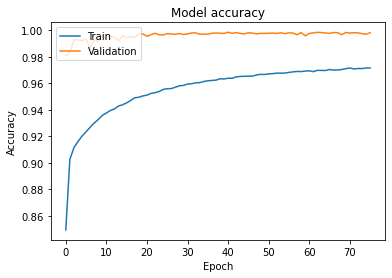

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

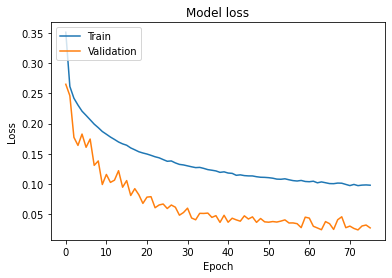

In [69]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Adasyn Training

In [83]:
history = model.fit(x_train_ADASYN, y_train_ADASYN, validation_split=0.2, batch_size=32, epochs=30, )

Epoch 1/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1343 - accuracy: 0.9518 - val_loss: 2.1926 - val_accuracy: 0.3005
Epoch 2/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1171 - accuracy: 0.9574 - val_loss: 2.2913 - val_accuracy: 0.3028
Epoch 3/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1134 - accuracy: 0.9585 - val_loss: 2.1793 - val_accuracy: 0.3031
Epoch 4/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1124 - accuracy: 0.9591 - val_loss: 1.8484 - val_accuracy: 0.2968
Epoch 5/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1117 - accuracy: 0.9594 - val_loss: 2.5541 - val_accuracy: 0.2958
Epoch 6/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1107 - accuracy: 0.9595 - val_loss: 2.0873 - val_accuracy: 0.2883
Epoch 7/30
776/776 [==============================] - 3s 4ms/step - loss: 0.1113 - accuracy: 0.9602 - val_loss: 2.3481 - val_accuracy: 0.3022
Epoch 

In [84]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test_data, y_test_data, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2/2 [==============================] - 0s 4ms/step - loss: 2.4305 - accuracy: 0.5684
test loss, test acc: [2.4304726123809814, 0.568359375]


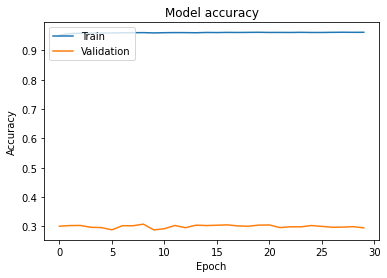

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

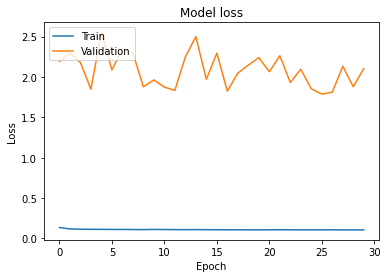

In [86]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Balanced Normal Data Training

In [87]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=150, callbacks=[callback])

Epoch 1/150
28/28 [==============================] - 0s 6ms/step - loss: 0.4825 - accuracy: 0.8577 - val_loss: 0.2867 - val_accuracy: 0.8647
Epoch 2/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2833 - accuracy: 0.8823 - val_loss: 0.2370 - val_accuracy: 0.9062
Epoch 3/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2573 - accuracy: 0.8917 - val_loss: 0.2085 - val_accuracy: 0.9058
Epoch 4/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2360 - accuracy: 0.9002 - val_loss: 0.2042 - val_accuracy: 0.8987
Epoch 5/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2286 - accuracy: 0.9069 - val_loss: 0.2051 - val_accuracy: 0.8853
Epoch 6/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2140 - accuracy: 0.9093 - val_loss: 0.2030 - val_accuracy: 0.9138
Epoch 7/150
28/28 [==============================] - 0s 5ms/step - loss: 0.2092 - accuracy: 0.9063 - val_loss: 0.2037 - val_accuracy: 0.9125
Epoch 8/150
2

In [88]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test_data, y_test_data, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
2/2 [==============================] - 0s 3ms/step - loss: 0.1113 - accuracy: 0.9461
test loss, test acc: [0.1112910807132721, 0.946093738079071]


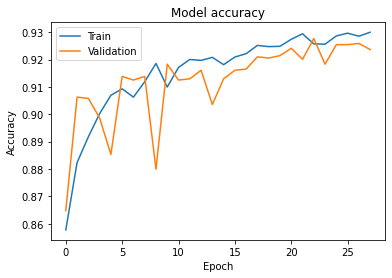

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

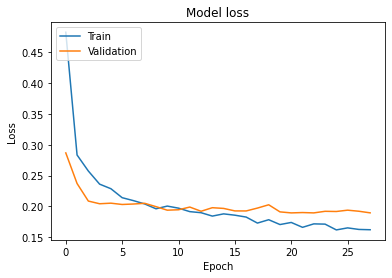

In [90]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [91]:
history.history

{'loss': [0.48251816630363464,
  0.2833097279071808,
  0.25728869438171387,
  0.23599697649478912,
  0.22859448194503784,
  0.21401438117027283,
  0.20924776792526245,
  0.20385275781154633,
  0.19599954783916473,
  0.20038403570652008,
  0.19703322649002075,
  0.1913938969373703,
  0.18965663015842438,
  0.1841409057378769,
  0.18775397539138794,
  0.18560579419136047,
  0.18257194757461548,
  0.17280662059783936,
  0.17825213074684143,
  0.17041563987731934,
  0.1738174855709076,
  0.16591444611549377,
  0.17151395976543427,
  0.17110618948936462,
  0.16171075403690338,
  0.1650131493806839,
  0.16248439252376556,
  0.162000834941864],
 'accuracy': [0.8577182292938232,
  0.882326602935791,
  0.8917226791381836,
  0.9002236723899841,
  0.9069350957870483,
  0.9092841148376465,
  0.906264066696167,
  0.9118568897247314,
  0.9185682535171509,
  0.9099552631378174,
  0.9171141386032104,
  0.9200224280357361,
  0.9196867942810059,
  0.9208053946495056,
  0.918120801448822,
  0.92091727256

# Imbalanced Normal Data Training

In [98]:
history = model.fit(x_train_, y_train_, validation_split=0.2, batch_size=32, epochs=150, callbacks=[callback])

Epoch 1/150
327/327 [==============================] - 1s 4ms/step - loss: 0.1041 - accuracy: 0.9616 - val_loss: 0.0760 - val_accuracy: 0.9728
Epoch 2/150
327/327 [==============================] - 1s 4ms/step - loss: 0.0899 - accuracy: 0.9660 - val_loss: 0.0727 - val_accuracy: 0.9728
Epoch 3/150
327/327 [==============================] - 1s 4ms/step - loss: 0.0857 - accuracy: 0.9683 - val_loss: 0.0718 - val_accuracy: 0.9735
Epoch 4/150
327/327 [==============================] - 1s 4ms/step - loss: 0.0842 - accuracy: 0.9677 - val_loss: 0.0729 - val_accuracy: 0.9709
Epoch 5/150
327/327 [==============================] - 1s 3ms/step - loss: 0.0836 - accuracy: 0.9684 - val_loss: 0.0715 - val_accuracy: 0.9734
Epoch 6/150
327/327 [==============================] - 1s 4ms/step - loss: 0.0802 - accuracy: 0.9698 - val_loss: 0.0732 - val_accuracy: 0.9707
Epoch 7/150
327/327 [==============================] - 1s 4ms/step - loss: 0.0799 - accuracy: 0.9694 - val_loss: 0.0713 - val_accuracy: 0.9734

In [99]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test_, y_test_, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
26/26 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9716
test loss, test acc: [0.0791737511754036, 0.9715818762779236]


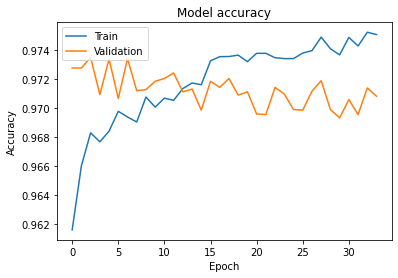

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

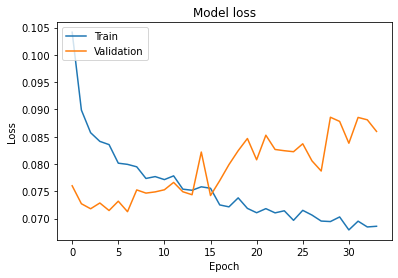

In [101]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()